**Objective of the competition:**

The competition dataset contains text from works of fiction written by spooky authors of the public domain: 
 1. Edgar Allan Poe (EAP)
 2. HP Lovecraft (HPL)
 3. Mary Wollstonecraft Shelley (MWS)
 
The objective  is to accurately identify the author of the sentences in the test set.

**Objective of the notebook:**

In this notebook, let us try to create different features that will help us in identifying the spooky authors. 

As a first step, we will do some basic data visualization and cleaning before we delve deep into the feature engineering part.

In [1]:
import sys
sys.path.append("../../python/")

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


We can check the number of occurrence of each of the author to see if the classes are balanced. 

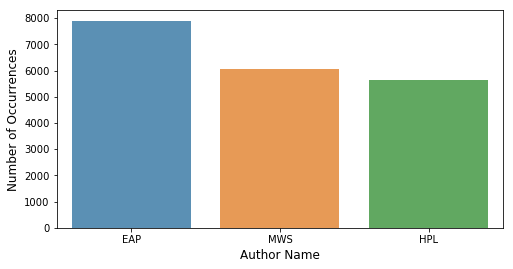

In [5]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

This looks good. There is not much class imbalance. Let us print some lines of each of the authors to try and understand their writing style if possible.

In [6]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

Only thing I can see is that there are quite a few special characters present in the text data. So count of these special characters might be a good feature. Probably we can create them later.

Apart from that, I do not have much clue.. In case if you find any interesting styles (features which we can create), please add them in the comments. 

**Feature Engineering:**

Now let us come try to do some feature engineering. This consists of two main parts.

 1. Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
 2. Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

**Meta Features:**

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords 
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words


In [7]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [8]:
train_df.head()

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481


Let us now plot some of our new variables to see of they will be helpful in predictions.

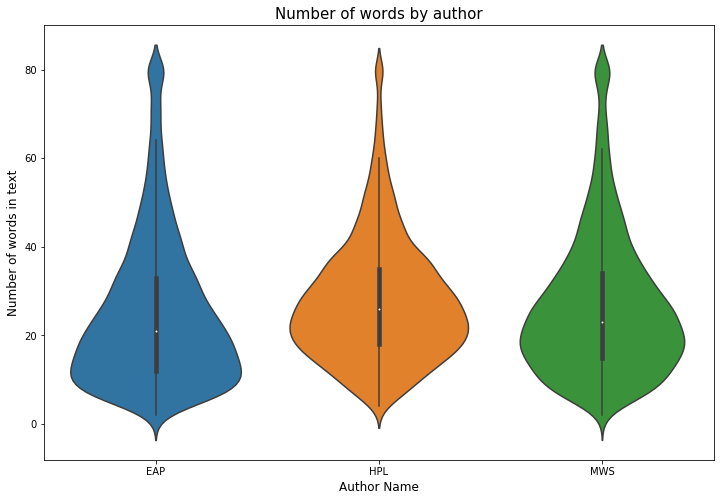

In [9]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

EAP seems slightly lesser number of words than MWS and HPL. 

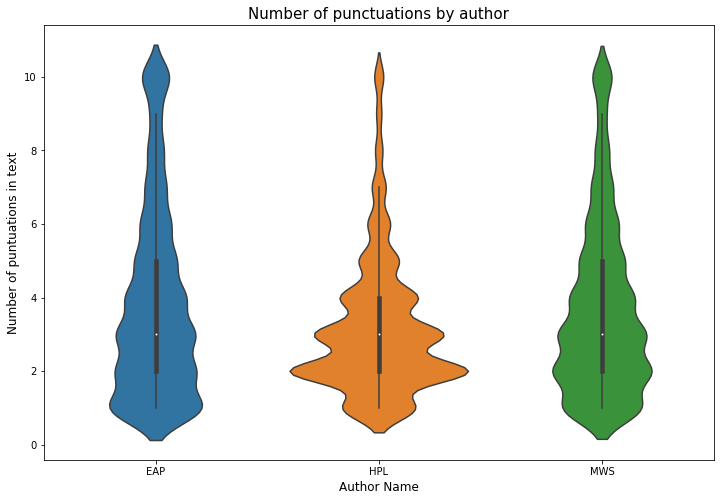

In [10]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

This also seems to be somewhat useful. Now let us focus on creating some text based features. 

Let us first build a basic model to see how these meta features  are helping. 

In [11]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

We can train a simple XGBoost model. 

In [12]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

For the sake of kernel run time, we can just check the first fold in the k-fold cross validation for the scores. Please remove the 'break' line while running in local.

In [13]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09449	test-mlogloss:1.09516
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04432	test-mlogloss:1.05531
[40]	train-mlogloss:1.02333	test-mlogloss:1.03909
[60]	train-mlogloss:1.0077	test-mlogloss:1.02641
[80]	train-mlogloss:0.995189	test-mlogloss:1.01622
[100]	train-mlogloss:0.987562	test-mlogloss:1.01193
[120]	train-mlogloss:0.980602	test-mlogloss:1.00762
[140]	train-mlogloss:0.975115	test-mlogloss:1.00435
[160]	train-mlogloss:0.970039	test-mlogloss:1.00162
[180]	train-mlogloss:0.965437	test-mlogloss:0.999482
[200]	train-mlogloss:0.961197	test-mlogloss:0.997566
[220]	train-mlogloss:0.957497	test-mlogloss:0.996358
[240]	train-mlogloss:0.954508	test-mlogloss:0.995064
[260]	train-mlogloss:0.951444	test-mlogloss:0.994385
[280]	train-mlogloss:0.947614	test-mlogloss:0.99326
[300]	train-mlogloss:0.944491	test-mlogloss:0.992291
[320]	train-mlogloss:0

We are getting a mlogloss of '0.987' using just the meta features. Not a bad score. Now let us see which of these features are important.

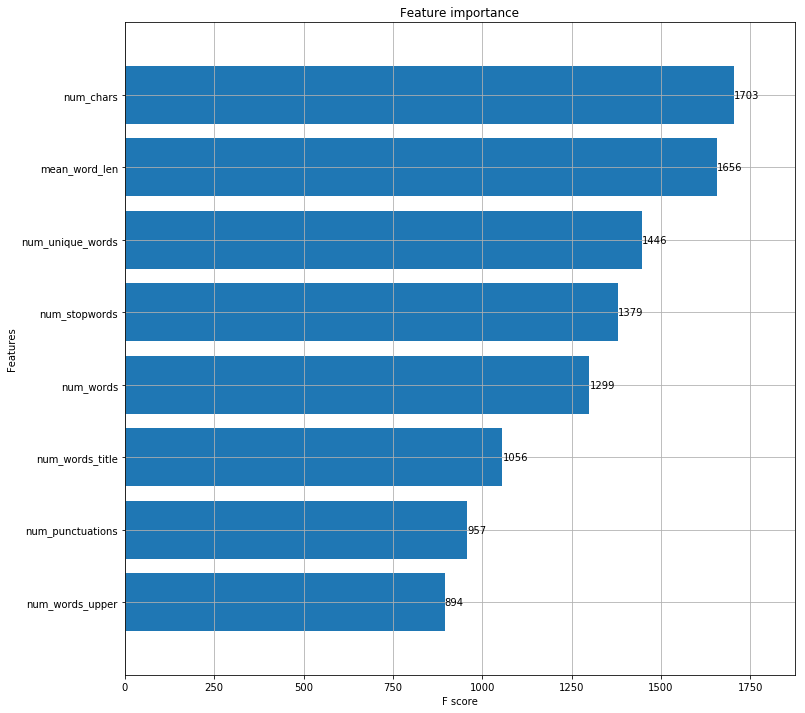

In [14]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

Number of characters, mean word length and number of unique words turn out to be the top 3 variables. Now let us focus on creating some text based features. 

**Text Based Features :**

One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.


In [15]:
import spacy

def extract_lemmas(df: pd.DataFrame, text_col, nlp=spacy.load('en')):
    stopwords = nltk.corpus.stopwords.words('english')

    def cleaning(sentence):
        sentence = nlp(sentence)
        tokens = [token.lemma_ for token in sentence if not token.is_punct | token.is_space | token.is_bracket | (token.text in stopwords)]
        return ' '.join(tokens)

    df = df.assign(nlp_processed = lambda rows : rows[text_col].map(lambda row: cleaning(row)))

    return df

In [16]:
train_df = extract_lemmas(train_df, "text")
test_df = extract_lemmas(test_df, "text")

In [17]:
train_df.head()

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,nlp_processed
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537,this process however afford means ascertain di...
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857,-PRON- never occur fumbling may mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333,in left hand gold snuff box caper hill cut man...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235,how lovely spring as look windsor terrace sixt...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481,find nothing else even gold superintendent aba...


In [18]:
text_col = "text"

In [19]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df[text_col].values.tolist() + test_df[text_col].values.tolist())
train_tfidf = tfidf_vec.transform(train_df[text_col].values.tolist())
test_tfidf = tfidf_vec.transform(test_df[text_col].values.tolist())

Now that we have got the tfidf vector, here is the tricky part. The tfidf output is a sparse matrix and so if we have to use it with other dense features, we have couple of choices. 
1. We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, convert it into dense format and concat with other features. 
2. Build a model using just the sparse features and then use the predictions as one of the features along with other dense features.

Based on the dataset, one might perform better than the other. Here we can use the second approach since there are some very [good scoring kernels](https://www.kaggle.com/the1owl/python-tell-tale-tutorial) using all the features of tfidf.

Also it seems that, [Naive Bayes is performing better](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399) in this dataset. So we could build a naive bayes model using tfidf features as it is faster to train.

In [20]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

**Naive Bayes on Word Tfidf Vectorizer:**

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.842216198361


We are getting a mlogloss of 0.844 using just tfidf vectorizer. Much better than the meta features. We can now create frequency features and see how it is performing.

**Naive Bayes on Word Count Vectorizer:**

In [22]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df[text_col].values.tolist() + test_df[text_col].values.tolist())
train_tfidf = tfidf_vec.transform(train_df[text_col].values.tolist())
test_tfidf = tfidf_vec.transform(test_df[text_col].values.tolist())

Now let us build Multinomial NB model using count vectorizer based features..

In [23]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]



Mean cv score :  0.450918416166


Wow. We got a cross validation mlogloss of 0.451 using count vectorizer inplace of tfidf vectorizer. LB score using this model is 0.468. 

** Naive Bayes on Character Count Vectorizer:**

One idea from the "data eyeballing" is that counting the special charaters might help. Instead of just counting the special characters, we can use the count vectorizer at character level to get some features. Again we can run Multinomial NB on top of it.

In [24]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df[text_col].values.tolist() + test_df[text_col].values.tolist())
train_tfidf = tfidf_vec.transform(train_df[text_col].values.tolist())
test_tfidf = tfidf_vec.transform(test_df[text_col].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.75076392268


The cross val score is very high and is 3.75. But this might add some different information than word level features and so let us use this for the final model as well.

**Naive Bayes on Character Tfidf Vectorizer:**

Let us also get the naive bayes predictions on the character tfidf vectorizer.

In [25]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df[text_col].values.tolist() + test_df[text_col].values.tolist())
train_tfidf = tfidf_vec.transform(train_df[text_col].values.tolist())
test_tfidf = tfidf_vec.transform(test_df[text_col].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947


In [26]:
Stop here!

SyntaxError: invalid syntax (<ipython-input-26-14848333e890>, line 1)

In [31]:
fast_text_train_df = pd.read_csv("trainset_fast_text_text_pos_bigrams.csv")
fast_text_train_df.head()

,id,EAP,HPL,MWS
0,id26305,0.416499,0.330872,0.252629
1,id17569,0.390859,0.299751,0.309390
2,id11008,0.403418,0.322350,0.274232
3,id27763,0.404111,0.325107,0.270782
4,id12958,0.398606,0.313061,0.288333


In [29]:
fast_text_test_df = pd.read_csv("fast_text_text_pos_bigrams.csv")
fast_text_test_df.head()

,id,EAP,HPL,MWS
0,id02310,0.128533,0.035294,0.836174
1,id24541,0.999532,0.000445,0.000022
2,id00134,0.094124,0.901347,0.004529
3,id27757,0.938145,0.051205,0.010650
4,id04081,0.553250,0.148045,0.298705


In [32]:
train_df["fast_text_eap"] = fast_text_train_df['EAP']
train_df["fast_text_hpl"] =  fast_text_train_df['HPL']
train_df["fast_text_mws"] = fast_text_train_df['MWS']
test_df["fast_text_eap"] =  fast_text_test_df['EAP']
test_df["fast_text_hpl"] = fast_text_test_df['HPL']
test_df["fast_text_mws"] = fast_text_test_df['MWS']

**XGBoost model:**

Now with the three new variables, we can re-run the xgboost model and evaluate the results.

In [34]:
cols_to_drop = ['id', 'text','nlp_processed']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [35]:
train_X

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws,nb_cvec_char_eap,nb_cvec_char_hpl,nb_cvec_char_mws,nb_tfidf_char_eap,nb_tfidf_char_hpl,nb_tfidf_char_mws,fast_text_eap,fast_text_hpl,fast_text_mws
0,41,35,231,19,7,2,3,4.658537,9.999933e-01,2.752790e-06,3.990111e-06,1.000000e+00,1.028776e-148,5.304438e-114,0.985953,0.002341,0.011706,0.416499,0.330872,0.252629
1,14,14,71,8,1,0,1,4.142857,8.226820e-01,1.492107e-01,2.810727e-02,1.000000e+00,1.183122e-10,3.052757e-19,0.758384,0.117523,0.124093,0.390859,0.299751,0.309390
2,36,32,200,16,5,0,1,4.583333,9.999918e-01,8.206128e-06,1.064720e-08,1.000000e+00,4.399079e-66,2.669182e-142,0.960568,0.030369,0.009062,0.403418,0.322350,0.274232
3,34,32,206,13,4,0,4,5.088235,1.436890e-09,7.472578e-10,1.000000e+00,3.922452e-164,5.948687e-107,1.000000e+00,0.119766,0.042625,0.837609,0.404111,0.325107,0.270782
4,27,25,174,11,4,0,2,5.481481,8.960309e-01,1.016456e-01,2.323469e-03,1.000000e+00,6.600385e-45,1.753184e-53,0.913891,0.036673,0.049436,0.398606,0.313061,0.288333
5,83,66,468,43,6,5,5,4.650602,2.263635e-05,1.736679e-10,9.999774e-01,1.591718e-75,3.412518e-264,1.000000e+00,0.829203,0.003832,0.166965,0.439522,0.359909,0.200569
6,21,21,128,9,5,0,1,5.142857,9.824786e-01,1.649424e-02,1.027174e-03,1.000000e+00,7.613535e-87,2.683399e-102,0.969976,0.017876,0.012148,0.397187,0.311676,0.291137
7,8,8,43,4,1,0,1,4.500000,9.292323e-01,4.516132e-02,2.560639e-02,1.000000e+00,3.117329e-15,4.023286e-18,0.747761,0.127616,0.124622,0.388390,0.299471,0.312139
8,88,62,488,45,10,4,7,4.556818,9.993470e-01,6.530103e-04,1.825069e-08,1.000000e+00,2.099525e-173,1.439362e-147,0.950049,0.009426,0.040525,0.440477,0.371665,0.187858
9,23,18,144,11,3,1,1,5.304348,3.346012e-02,5.434045e-03,9.611058e-01,1.027740e-15,1.495289e-49,1.000000e+00,0.734956,0.038325,0.226719,0.401977,0.311643,0.286380


In [ ]:
text_col

In [36]:


kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.9)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.99976	test-mlogloss:0.999911
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.408384	test-mlogloss:0.414041
[40]	train-mlogloss:0.343886	test-mlogloss:0.355453
[60]	train-mlogloss:0.328068	test-mlogloss:0.343575
[80]	train-mlogloss:0.316272	test-mlogloss:0.336749
[100]	train-mlogloss:0.307276	test-mlogloss:0.333345
[120]	train-mlogloss:0.299834	test-mlogloss:0.331143
[140]	train-mlogloss:0.292752	test-mlogloss:0.329812
[160]	train-mlogloss:0.286312	test-mlogloss:0.329212
[180]	train-mlogloss:0.280112	test-mlogloss:0.32805
[200]	train-mlogloss:0.274785	test-mlogloss:0.327653
[220]	train-mlogloss:0.269427	test-mlogloss:0.327057
[240]	train-mlogloss:0.26424	test-mlogloss:0.326941
[260]	train-mlogloss:0.259477	test-mlogloss:0.326763
[280]	train-mlogloss:0.255228	test-mlogloss:0.326743
[300]	train-mlogloss:0.250888	test-mlogloss:0.326766
[320]	trai

In [37]:
out_df

,id,EAP,HPL,MWS
0,id02310,0.112144,0.001603,0.886253
1,id24541,0.999449,0.000363,0.000188
2,id00134,0.072123,0.924623,0.003254
3,id27757,0.623794,0.374970,0.001236
4,id04081,0.942540,0.017476,0.039984
5,id27337,0.948600,0.044547,0.006853
6,id24265,0.904777,0.082452,0.012771
7,id25917,0.034213,0.032694,0.933093
8,id04951,0.994530,0.004864,0.000606
9,id14549,0.898621,0.022673,0.078706


**This has a val score of 0.3254 and LB score of 0.3xxx.** Running it on all the folds might give a better score. Now let us check the important variables again.

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model,  height=0.8, ax=ax)
plt.show()

**Next steps in this FE notebook:**
* Using SVD features
* Using word embedding based features 
* Other meta features if any

**Ideas for further improvements:**
* Parameter tuning for tfidf and count vectorizer
* Parameter tuning for naive bayes and XGB models
* Ensembling / Stacking with other models


**More to come. Stay tuned.!**